# ADS505 Final Project (Team 2)

## Required Packages

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

## Descriptive Analytics

In [21]:
# load the dataset
df = pd.read_csv('./Big_Black_Money_Dataset.csv')
df.head()

,Transaction ID,Country,Amount (USD),Transaction Type,Date of Transaction,Person Involved,Industry,Destination Country,Reported by Authority,Source of Money,Money Laundering Risk Score,Shell Companies Involved,Financial Institution,Tax Haven Country
0,TX0000000001,Brazil,3.267530e+06,Offshore Transfer,2013-01-01 00:00:00,Person_1101,Construction,USA,True,Illegal,6,1,Bank_40,Singapore
1,TX0000000002,China,4.965767e+06,Stocks Transfer,2013-01-01 01:00:00,Person_7484,Luxury Goods,South Africa,False,Illegal,9,0,Bank_461,Bahamas
2,TX0000000003,UK,9.416750e+04,Stocks Transfer,2013-01-01 02:00:00,Person_3655,Construction,Switzerland,True,Illegal,1,3,Bank_387,Switzerland
3,TX0000000004,UAE,3.864201e+05,Cash Withdrawal,2013-01-01 03:00:00,Person_3226,Oil & Gas,Russia,False,Illegal,7,2,Bank_353,Panama
4,TX0000000005,South Africa,6.433784e+05,Cryptocurrency,2013-01-01 04:00:00,Person_7975,Real Estate,USA,True,Illegal,1,9,Bank_57,Luxembourg


In [22]:
# Data Structure
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction ID               10000 non-null  object 
 1   Country                      10000 non-null  object 
 2   Amount (USD)                 10000 non-null  float64
 3   Transaction Type             10000 non-null  object 
 4   Date of Transaction          10000 non-null  object 
 5   Person Involved              10000 non-null  object 
 6   Industry                     10000 non-null  object 
 7   Destination Country          10000 non-null  object 
 8   Reported by Authority        10000 non-null  bool   
 9   Source of Money              10000 non-null  object 
 10  Money Laundering Risk Score  10000 non-null  int64  
 11  Shell Companies Involved     10000 non-null  int64  
 12  Financial Institution        10000 non-null  object 
 13  Tax Haven Country

## Univariate Analysis

In [23]:
# Summary statistics
print(df.describe())
print()

# Unique Value Counts
print('Unique Column Values Count')
print('-------------------------------')
print(df.nunique())

       Amount (USD)  Money Laundering Risk Score  Shell Companies Involved
count  1.000000e+04                 10000.000000              10000.000000
mean   2.501818e+06                     5.526400                  4.469400
std    1.424364e+06                     2.893603                  2.879773
min    1.003180e+04                     1.000000                  0.000000
25%    1.279005e+06                     3.000000                  2.000000
50%    2.501310e+06                     6.000000                  4.000000
75%    3.722416e+06                     8.000000                  7.000000
max    4.999812e+06                    10.000000                  9.000000

Unique Column Values Count
-------------------------------
Transaction ID                 10000
Country                           10
Amount (USD)                   10000
Transaction Type                   5
Date of Transaction            10000
Person Involved                 6320
Industry                           7
Destin

## Multivariate Analysis

### Correlation Heatmap

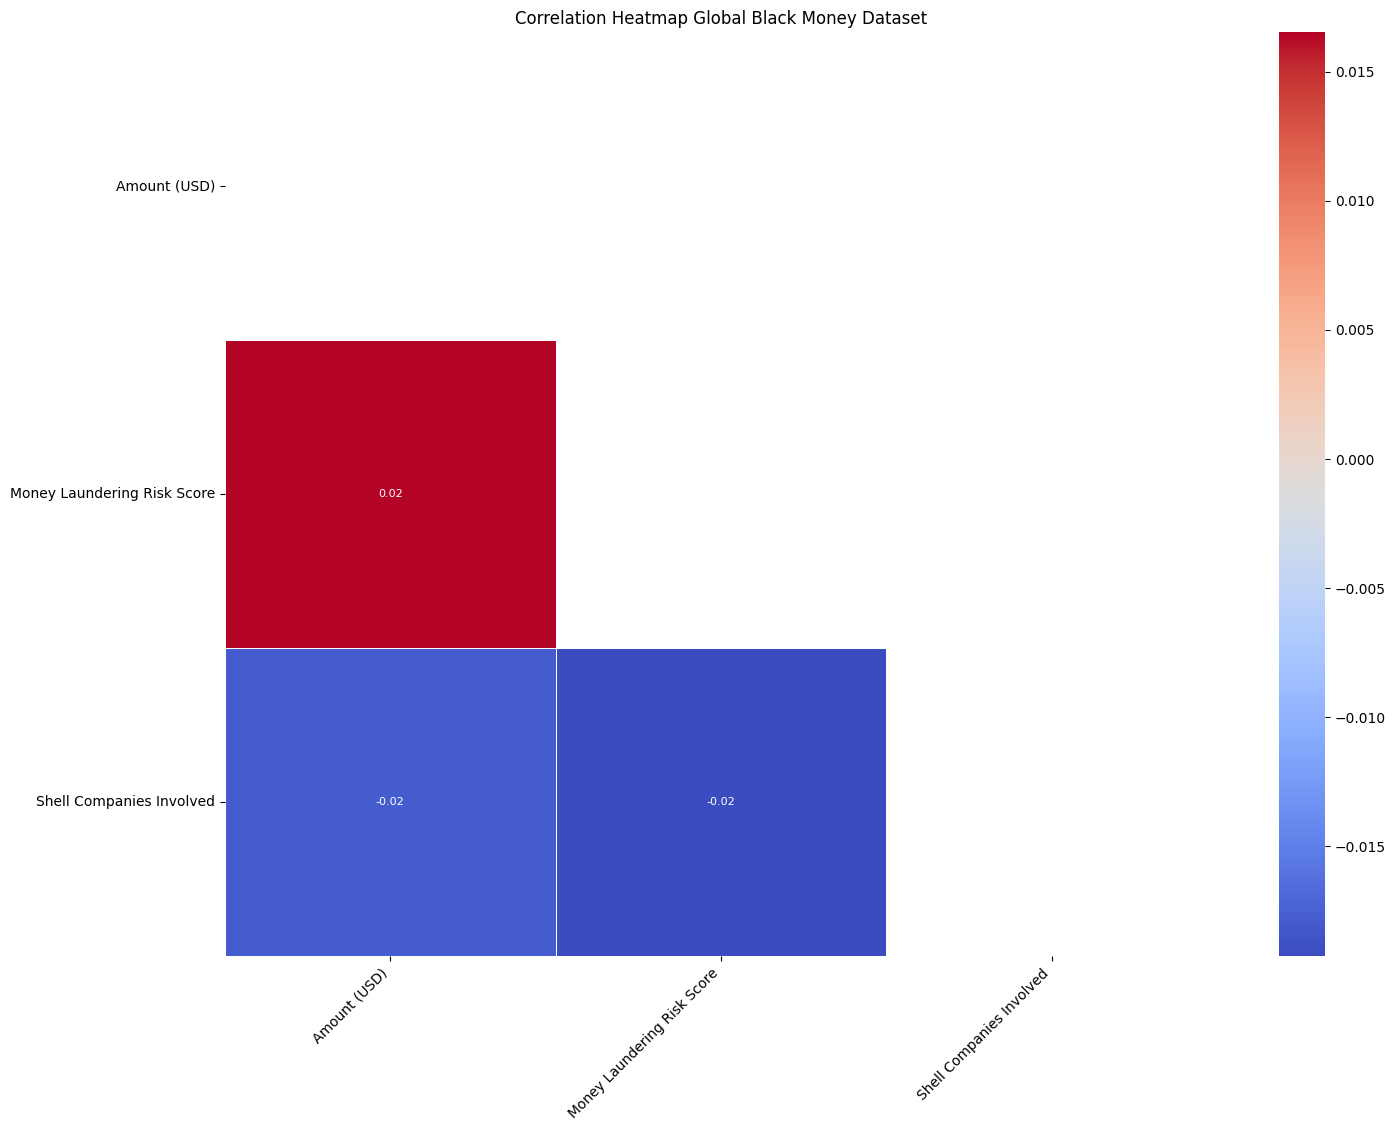

In [24]:
# Define Numeric Variables
numeric_predictors = ['Amount (USD)', 'Money Laundering Risk Score',  'Shell Companies Involved']

# Init Correlation Matrix
corr_matrix = df[numeric_predictors].corr()

# Create a heatmap
corr_matrix = corr_matrix

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})

# Rotate the x and y labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Heatmap Global Black Money Dataset')

# Show the heatmap
plt.show()

Source of Money
Illegal    7017
Legal      2983
Name: count, dtype: int64


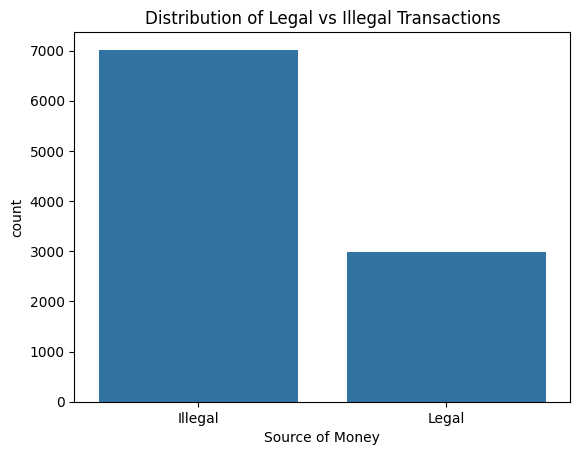

In [25]:
# Distribution of illegal vs legal transactions
print(df['Source of Money'].value_counts())

sns.countplot(x='Source of Money', data=df)
plt.title('Distribution of Legal vs Illegal Transactions')
plt.show()

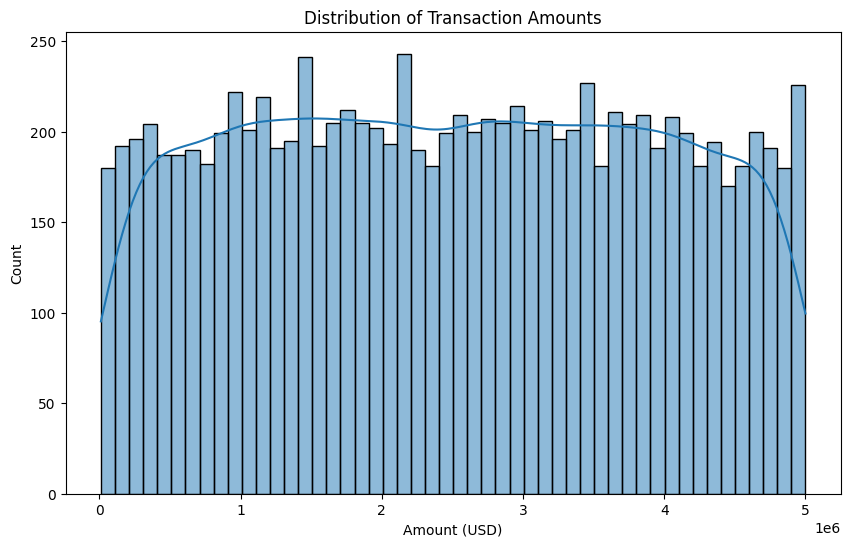

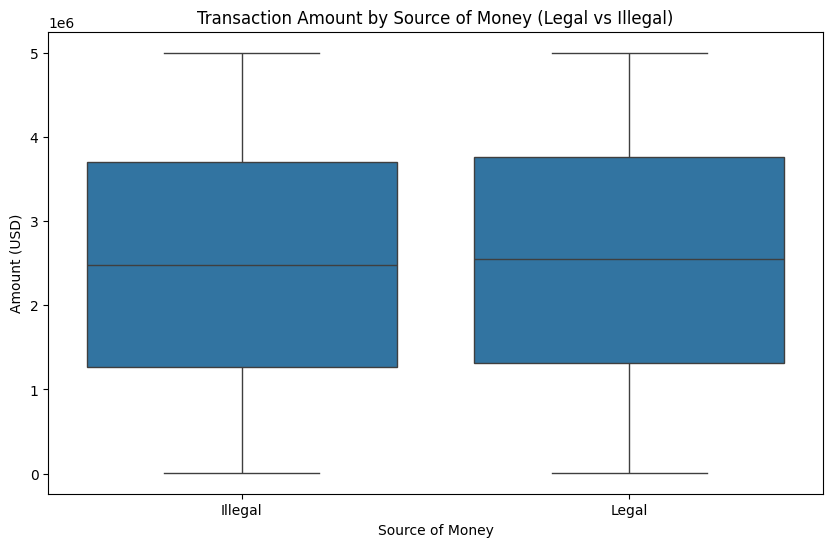

In [26]:
# Distribution of the overall transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(df['Amount (USD)'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.show()

# Boxplot to compare Amount by Source of Money
plt.figure(figsize=(10, 6))
sns.boxplot(x='Source of Money', y='Amount (USD)', data=df)
plt.title('Transaction Amount by Source of Money (Legal vs Illegal)')
plt.show()

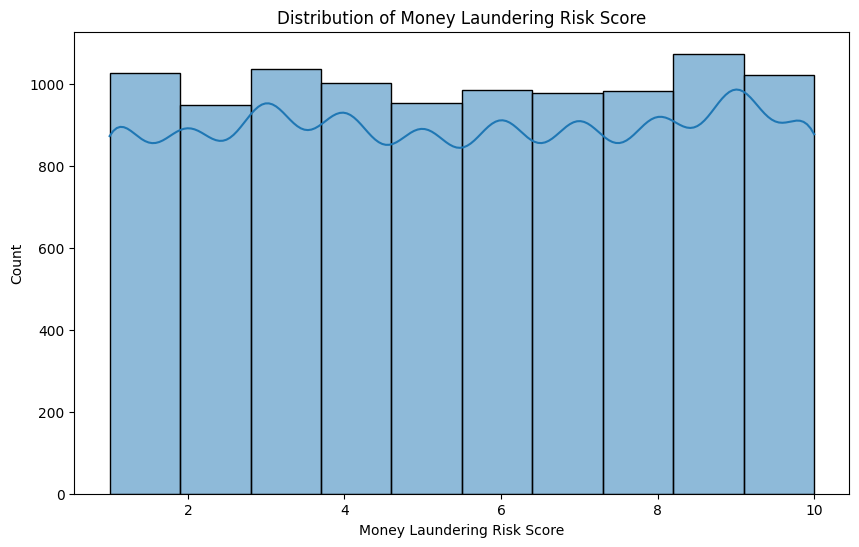

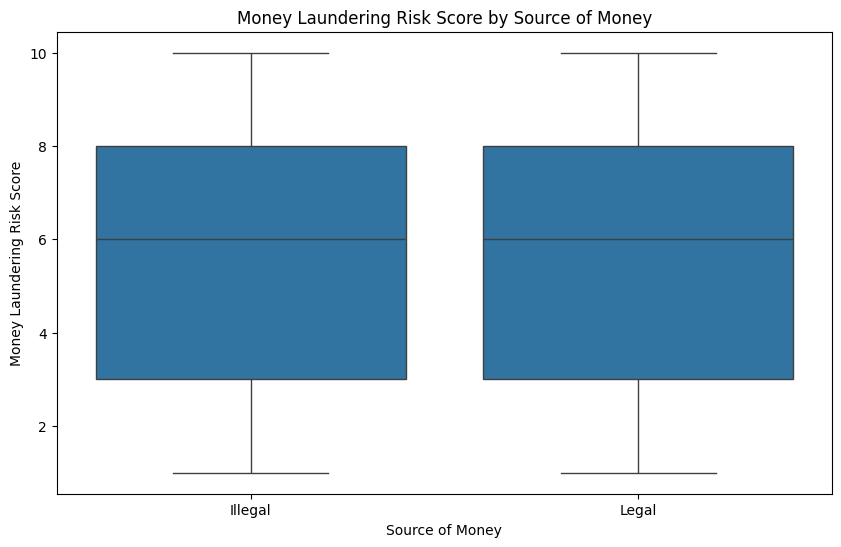

In [27]:
# Money Laundering Risk Score
plt.figure(figsize=(10, 6))
sns.histplot(df['Money Laundering Risk Score'], bins=10, kde=True)
plt.title('Distribution of Money Laundering Risk Score')
plt.show()

# Boxplot to compare Risk Score by Source of Money
plt.figure(figsize=(10, 6))
sns.boxplot(x='Source of Money', y='Money Laundering Risk Score', data=df)
plt.title('Money Laundering Risk Score by Source of Money')
plt.show()

Country
Brazil          748
South Africa    728
China           711
UK              708
Russia          701
India           695
Switzerland     687
UAE             685
Singapore       685
USA             669
Name: count, dtype: int64


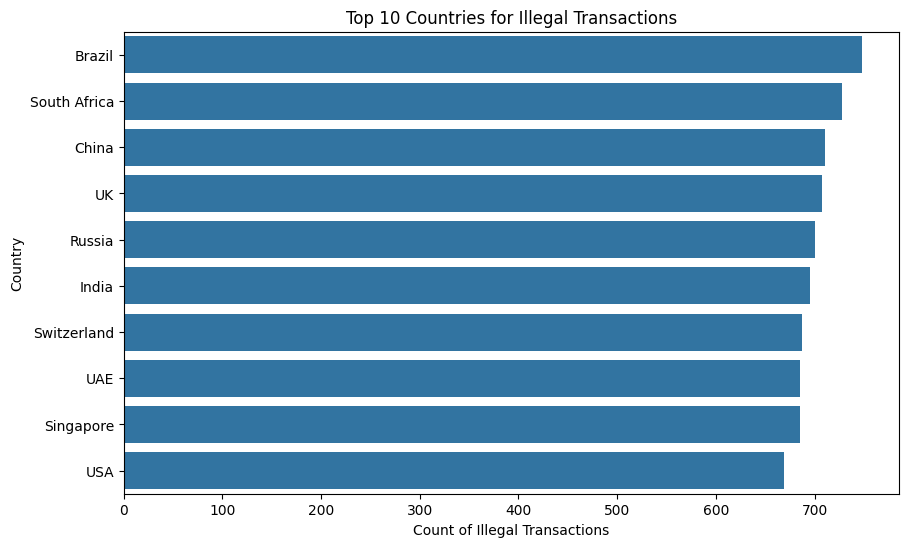

In [28]:
# Top countries for illegal transactions
illegal_countries = df[df['Source of Money'] == 'Illegal']['Country'].value_counts().head(10)
print(illegal_countries)

# top 10 countries
plt.figure(figsize=(10, 6))
sns.barplot(x=illegal_countries.values, y=illegal_countries.index)
plt.title('Top 10 Countries for Illegal Transactions')
plt.xlabel('Count of Illegal Transactions')
plt.show()

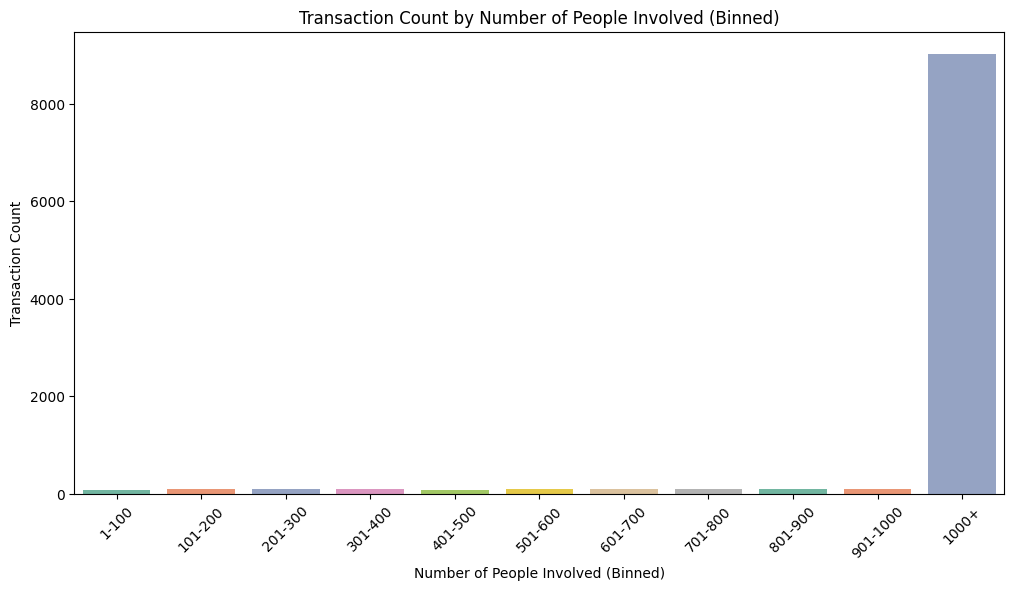

In [29]:
# Clean 'Person Involved' column by extracting numeric values from strings
df['Person Involved'] = pd.to_numeric(df['Person Involved'].str.extract('(\d+)')[0], errors='coerce')
df.dropna(subset=['Person Involved'], inplace=True)
df['Person Involved'] = df['Person Involved'].astype(int)

# Binning
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, df['Person Involved'].max()]  # Define bins
labels = ['1-100', '101-200', '201-300', '301-400', '401-500', '501-600', '601-700', '701-800', '801-900', '901-1000', '1000+']  # Define labels for the bins

# Create a new column for binned data
df['Person Involved Binned'] = pd.cut(df['Person Involved'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(12, 6))
sns.countplot(x='Person Involved Binned', data=df, palette='Set2')
plt.title('Transaction Count by Number of People Involved (Binned)')
plt.xlabel('Number of People Involved (Binned)')
plt.ylabel('Transaction Count')
plt.xticks(rotation=45)
plt.show()


In [30]:
print(df.dtypes)

# Selecting categorical variables
categorical_vars = df.select_dtypes(include=['object', 'category']).columns.tolist()
print('Categorical Variables:', categorical_vars)

# Display unique values for categorical columns
for col in categorical_vars:
    print(f"{col}: {df[col].unique()}")

Transaction ID                   object
Country                          object
Amount (USD)                    float64
Transaction Type                 object
Date of Transaction              object
Person Involved                   int64
Industry                         object
Destination Country              object
Reported by Authority              bool
Source of Money                  object
Money Laundering Risk Score       int64
Shell Companies Involved          int64
Financial Institution            object
Tax Haven Country                object
Person Involved Binned         category
dtype: object
Categorical Variables: ['Transaction ID', 'Country', 'Transaction Type', 'Date of Transaction', 'Industry', 'Destination Country', 'Source of Money', 'Financial Institution', 'Tax Haven Country', 'Person Involved Binned']
Transaction ID: ['TX0000000001' 'TX0000000002' 'TX0000000003' ... 'TX0000009998'
 'TX0000009999' 'TX0000010000']
Country: ['Brazil' 'China' 'UK' 'UAE' 'South Africa

In [31]:
# Create dummy variables for categorical variables
df_dummies = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

# new DataFrame with dummy variables
print(df_dummies.head())

   Amount (USD)  Person Involved  Reported by Authority  \
0  3.267530e+06             1101                   True   
1  4.965767e+06             7484                  False   
2  9.416750e+04             3655                   True   
3  3.864201e+05             3226                  False   
4  6.433784e+05             7975                   True   

   Money Laundering Risk Score  Shell Companies Involved  \
0                            6                         1   
1                            9                         0   
2                            1                         3   
3                            7                         2   
4                            1                         9   

   Transaction ID_TX0000000002  Transaction ID_TX0000000003  \
0                        False                        False   
1                         True                        False   
2                        False                         True   
3                        False  

In [32]:
# Check for missing data
print(df.isnull().sum())

# Drop rows with missing values if needed
df.dropna(inplace=True)

Transaction ID                 0
Country                        0
Amount (USD)                   0
Transaction Type               0
Date of Transaction            0
Person Involved                0
Industry                       0
Destination Country            0
Reported by Authority          0
Source of Money                0
Money Laundering Risk Score    0
Shell Companies Involved       0
Financial Institution          0
Tax Haven Country              0
Person Involved Binned         1
dtype: int64
